# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
import scippneutron as scn
from scippneutron.conversion import graph
import os
from IPython.display import Image
import h5py
import sys
from TubeMeasurment_mccode import tube_measurement


## Data reduction process

Full overview of how converison is done: 

In [2]:

filename = '../McStasScript/data_folder/bifrost_62'
wedge = 0
arc = 4
tube = 0

I = np.loadtxt(str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat').reshape(3,1000,100)[0]
I = I.T
I_err = np.loadtxt(str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat').reshape(3,1000,100)[1]
I_err = I_err.T

file = str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat'

with open(file, 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    limits = all_data[28]
    limits = limits.replace('# xylimits: ', '')
    limits = limits.split(' ')
    limits = np.asarray(limits, dtype=float)
    t_s = np.linspace(limits[2], limits[3], 1000)
    y_m = np.linspace(limits[0], limits[1], 100)
    A4 = all_data[9]
    A4 = A4.replace('# Param: A4=', '')
    A4_offset = np.asarray(A4).astype('float')

    A3 = all_data[10]
    A3 = A3.replace('# Param: A3=', '')
    A3 = np.asarray(A3).astype('float')

# Scipp binning of one instrument setting

## Importing all tubes for a given A3, A4 setting.

In [41]:

#settings = tube_measurement.load_Backend_measurment('../McStasScript/data_folder/bifrost_62', Correct=True)

#print('Estimated memory size of a Backend measurment =',sys.getsizeof(settings)/1024, 'kB')

def load_scan(keyword, output_filename):
    # Search for files containing the keyword in the filename
    files_with_keyword = [file for file in os.listdir() if keyword in file]

    if not files_with_keyword:
        print("No files found with the specified keyword.")
        return
    
    with open(output_filename, 'a') as output_file:
        for file_with_keyword in files_with_keyword:
            
            # Load information from the file
            processed_data = tube_measurement.load_Backend_measurment(file_with_keyword)
            
            # Convert tuple of results to nd.array
            matrix = np.column_stack(processed_data)

            # Append processed data to output file
            np.savetxt(output_file, matrix, delimiter='\t', fmt='%f')
            output_file.write('\n')

load_scan('bifrost', 'output_test')

## Exporting dataformat for MJOLNIR

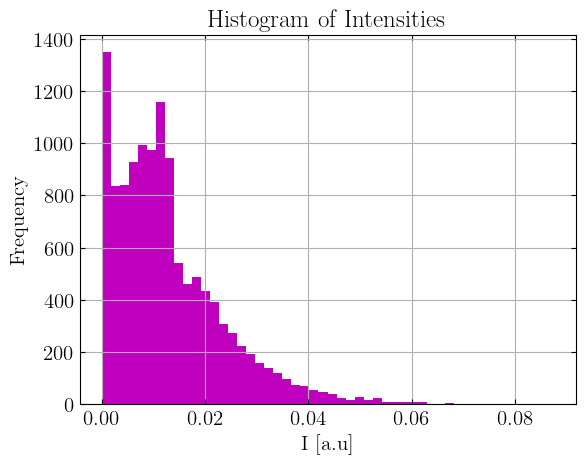

In [23]:
data_flat = settings[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.0001)], bins=50, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

In [24]:

"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data: I, I_err, DeltaE, qx, qy
ax.scatter(settings[3], settings[4], settings[2], c=settings[0])

ax.set_xlabel('qx')
ax.set_ylabel('qy')
ax.set_zlabel('DeltaE')
ax.set_title('tube measuring surface')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Plot data: I, I_err, DeltaE, qx, qy\nax.scatter(settings[3], settings[4], settings[2], c=settings[0])\n\nax.set_xlabel('qx')\nax.set_ylabel('qy')\nax.set_zlabel('DeltaE')\nax.set_title('tube measuring surface')\nplt.show()\n"

In [25]:


qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="Å^(-1)", variances=settings[1]), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=1300, Q=400)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:1300, Q:400, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.461247, 0.475251, ..., 6.04889, 6.06289]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-3.45462, -3.40705, ..., 58.3356, 58.3832]
Data:
                            float64           [1/Å]  (deltaE, Q)  [nan, nan, ..., 0, 0]  [nan, nan, ..., 0, 0]

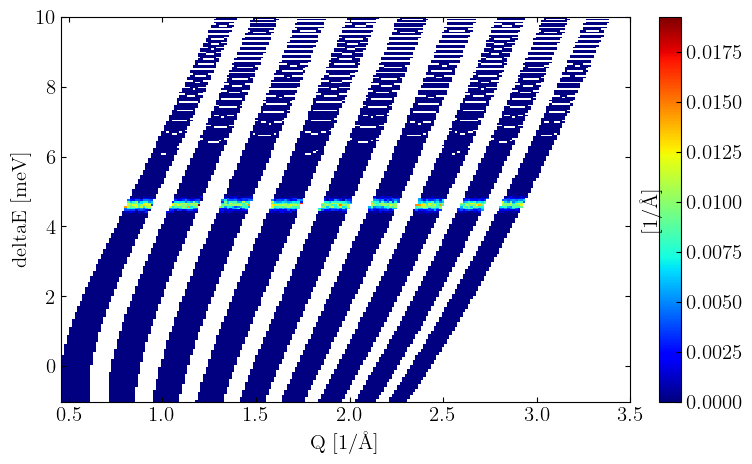

In [26]:
E_layer = 0 * sc.Unit('meV')
qy_layer = -1.53 * sc.Unit('Å^(-1)')

E_min = -1 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 3.5 * sc.Unit('Å^(-1)')

qx_min = 0 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

qy_min = -3.0 * sc.Unit('Å^(-1)')
qy_max = 3.0 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
#p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose().plot(ax=ax[0], cmap='jet')
#ax[0].set_xlim(0,2)
#ax[0].set_ylim(-0,-2)
#p2 = sliced['deltaE', E_min:E_max]['qy', qy_layer].transpose().plot(ax=ax[1], cmap='jet')
p3 = slicedQ['deltaE', E_min:E_max]['Q',Q_min:Q_max].plot(ax=ax, cmap='jet')